# Description

This notebook trains, tests and creates plots for the base autoencoder model with 4 hidden layers each for the encoder and decoder, and the latent space is of dimensions 3. 

* This is the **same** model as in Eric Wulff and Erik Wallin's codes for 4-momentum data compression. 

* No activation is used for the hidden layers as the data is not normalized and can lie beyond (-1,1). Having activation in the hidden layers burdens the last layer to perform scaling, which can reduce the performance.



*The data used in this notebook was not normalized. Refer 4D_data_normalization.ipynb for further details.* 

*Please note that to generate the train-validation loss plot, the test set is treated as the validation set, which theoretically is incorrect. However, I did not use the test set performance to determine the training schedule, so except for the loss plot, the test set is independent.*

### Load packages

In [1]:
import sys
BIN = 'utils/'
sys.path.append(BIN)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import fastai
from fastai.callbacks import ActivationStats
from fastai import data_block, basic_train, basic_data

import matplotlib as mpl
import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')
%matplotlib inline

In [2]:
from utils import plot_activations
from nn_utils import AE_3D_200_no_tanh


### Check for gpu

In [3]:
torch.cuda.is_available()

True

***Comment if you training is to be done on a CPU***

In [4]:
fastai.torch_core.defaults.device = 'cuda'

## Load data

In [5]:
train = pd.read_pickle('../datasets/non_normalized_train_4D_100_percent').astype(np.float32)
test = pd.read_pickle('../datasets/non_normalized_test_4D_100_percent').astype(np.float32)
n_features = len(train.loc[0])

train.head(10)

,m,pt,phi,eta
132784,3.831839,22.000608,1.567018,1.142924
99666,4.582417,21.648211,-2.680558,0.213654
26629,16.747766,169.514282,-1.948239,1.163296
80473,14.789587,183.085602,-1.641102,2.670927
48229,4.646724,20.527130,2.922270,-1.158871
61832,6.236774,30.013536,-2.962712,0.091814
26867,17.774944,205.705048,2.472530,-1.299140
46232,4.181292,20.511900,-1.937396,-1.893408
44194,4.537855,29.095221,2.703056,-1.746550
59782,6.769762,26.334354,1.344461,-2.599911


### Create database for training

In [6]:
train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

In [7]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs),
    )

In [8]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=512)

In [9]:
db = basic_data.DataBunch(train_dl, valid_dl)
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fd460b37278>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fd460b37240>;

Test: None

## Model definition

In [10]:
model = AE_3D_200_no_tanh()

### Loss = MSE

In [11]:
loss_func = nn.MSELoss()

### Training parameters

In [12]:
bn_wd = False  # Don't use weight decay for batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

### Find learning rate

In [22]:
from fastai import train as tr
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


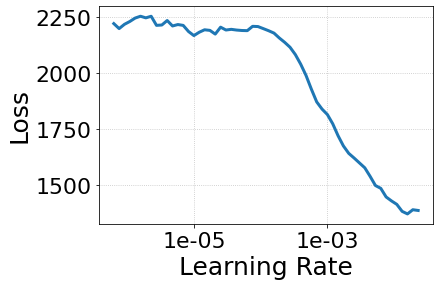

In [23]:
learn.recorder.plot()

### Start training

In [24]:
lr = 1e-6
learn.fit(1, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,2241.208008,2285.918701,00:02


### Train for 10 epochs with high learning rate

In [25]:
lr = 1e-4
learn.fit(10, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,15.162439,5.872992,00:02
1,5.617692,5.839047,00:02
2,3.517166,2.269155,00:02
3,1.420512,1.384650,00:02
4,1.246790,1.179778,00:02
5,0.626787,0.558481,00:02
6,0.546426,0.535392,00:02
7,0.540195,0.520503,00:02
8,0.531207,0.523465,00:02
9,0.536190,0.522923,00:02


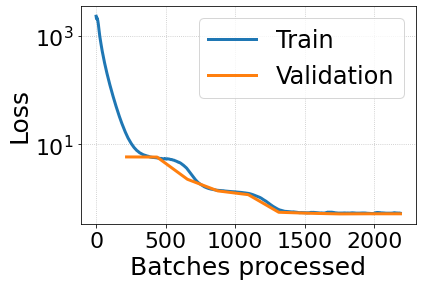

In [26]:
learn.recorder.plot_losses()
plt.yscale('log')

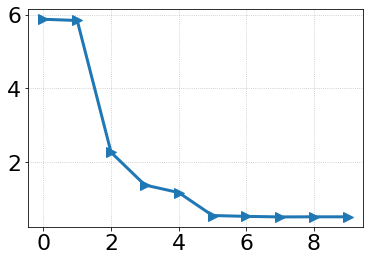

In [27]:
plt.plot(learn.recorder.val_losses, marker='>')

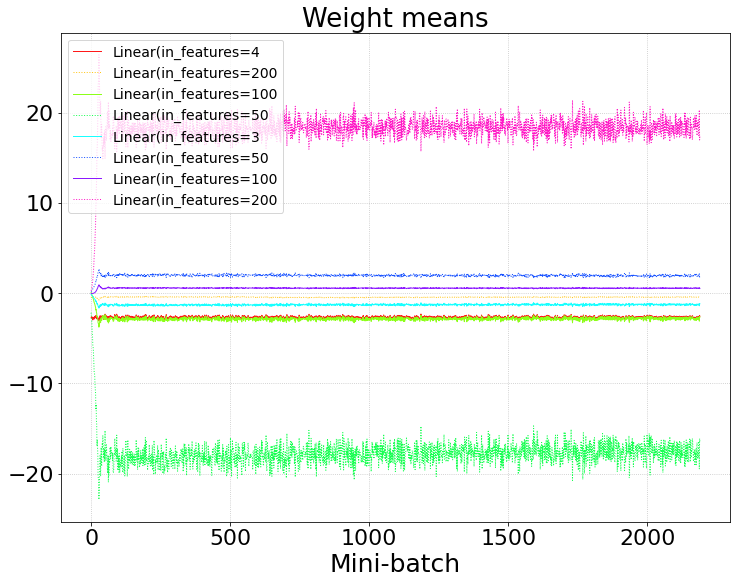

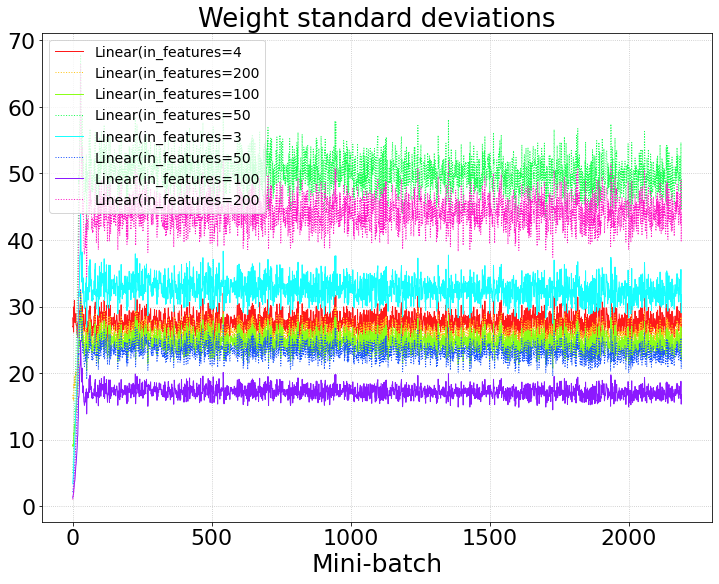

In [28]:
plot_activations(learn)

In [29]:
learn.save('AE_3D_200_no1cycle_no_norm')

### Train for 1000 more epochs with lower learning rate

In [30]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.525555,0.518152,00:02
1,0.518775,0.517838,00:02
2,0.525012,0.518259,00:02
3,0.526609,0.517859,00:02
4,0.524056,0.517827,00:02
5,0.522962,0.518370,00:02
6,0.521767,0.517951,00:02
7,0.521987,0.517889,00:02
8,0.526204,0.518089,00:02
9,0.524183,0.517992,00:02


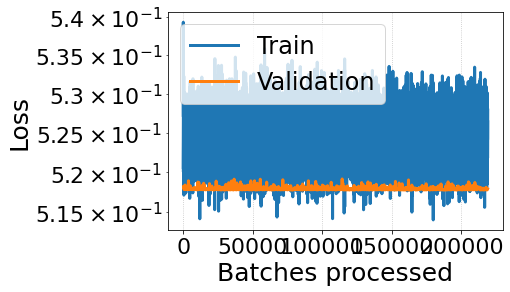

In [31]:
learn.recorder.plot_losses()
plt.yscale('log')

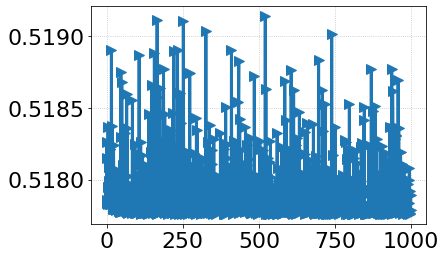

In [32]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [33]:
learn.save('AE_3D_200_no1cycle_no_norm')

### Train for 1000 more epochs

In [34]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.525082,0.517772,00:03
1,0.520029,0.517763,00:03
2,0.526133,0.517782,00:03
3,0.524898,0.517774,00:03
4,0.519804,0.518333,00:03
5,0.518728,0.517805,00:03
6,0.525547,0.517763,00:03
7,0.523398,0.518068,00:03
8,0.526739,0.517920,00:03
9,0.521722,0.517824,00:03


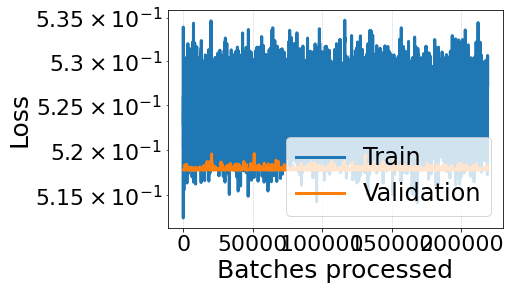

In [35]:
learn.recorder.plot_losses()
plt.yscale('log')

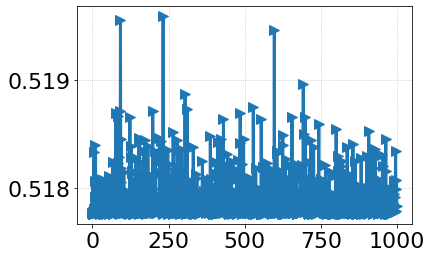

In [36]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [37]:
learn.save('AE_3D_200_no1cycle_no_norm')

### Train for 1000 more epochs 

In [38]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.524637,0.518041,00:02
1,0.524797,0.517762,00:02
2,0.520354,0.517769,00:02
3,0.526727,0.517894,00:02
4,0.523419,0.517854,00:02
5,0.523144,0.517762,00:02
6,0.522984,0.517794,00:02
7,0.525045,0.517777,00:02
8,0.522680,0.517765,00:02
9,0.522047,0.517823,00:02


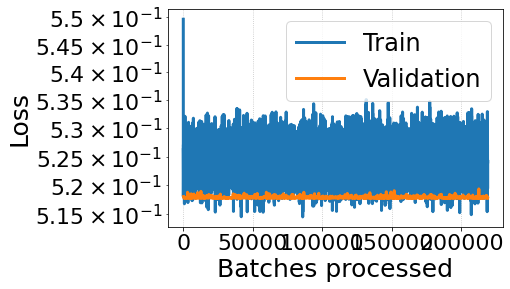

In [39]:
learn.recorder.plot_losses()
plt.yscale('log')

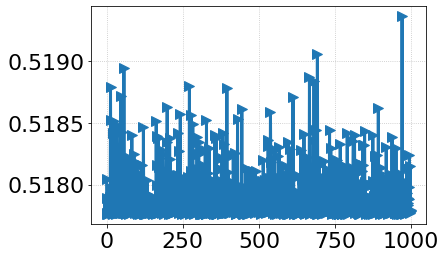

In [40]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [41]:
learn.save('AE_3D_200_no1cycle_no_norm')

### 1000 more ..

In [42]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.525187,0.517838,00:03
1,0.526848,0.517766,00:03
2,0.528491,0.517905,00:03
3,0.524189,0.517824,00:03
4,0.524376,0.517773,00:03
5,0.525711,0.517806,00:03
6,0.526563,0.517763,00:03
7,0.526325,0.518213,00:03
8,0.521274,0.518510,00:02
9,0.523282,0.517852,00:03


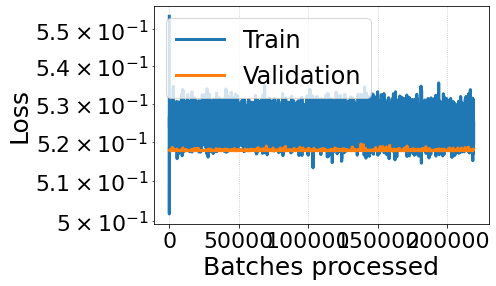

In [43]:
learn.recorder.plot_losses()
plt.yscale('log')

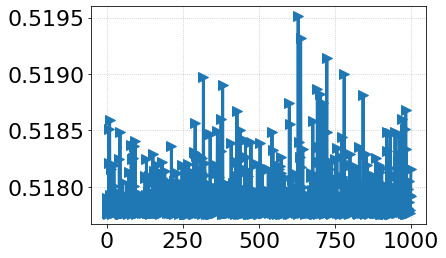

In [44]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [45]:
learn.save('AE_3D_200_no1cycle_no_norm')

### Since the training loss seems to be constant, we abort further training and accept this to be the best posible model that can be obtained for the given settings.

#### Note that I repeated the experiments 5 times, but everytime the saturates around ~0.517

--- 

## Test the model and build plots

In [13]:
learn.load('AE_3D_200_no1cycle_no_norm')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fd460b37278>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fd460b37240>;

Test: None, model=AE_3D_200_no_tanh(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_tim

### Evaluate on the test-set

In [14]:
learn.validate()

[0.5181589]

In [15]:
curr_save_folder = 'plots/AE_3D_200_no_norm/'

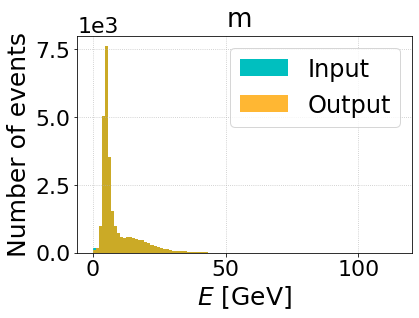

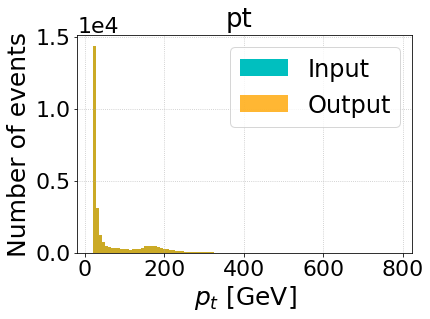

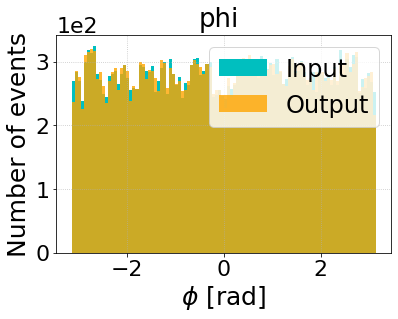

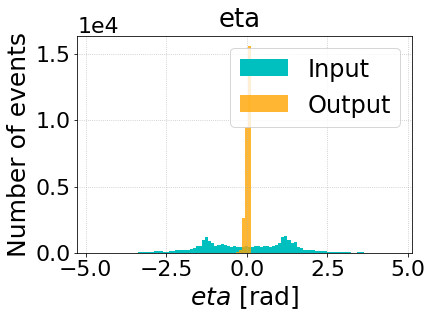

In [16]:
plt.close('all')
unit_list = ['[GeV]', '[GeV]', '[rad]', '[rad]']
variable_list = [r'$E$', r'$p_t$', r'$\phi$', r'$eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, len(test))  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()


alph = 0.8
n_bins = 100
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = '200_no_norm_hist%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

m Mean:  -0.005725111 \pm 0.0004515624389191959  Sigma:  0.07548525 \pm 0.00031929715839836546
pt Mean:  -1.969886e-06 \pm 1.2017004191368254e-07  Sigma:  2.0088175e-05 \pm 8.497152808228782e-08
phi Mean:  -0.004830446 \pm 0.003864051368235374  Sigma:  0.6459326 \pm 0.002732248265528055
eta Mean:  -1.0107529 \pm 0.03758599716234057  Sigma:  6.283048 \pm 0.026576839479272925


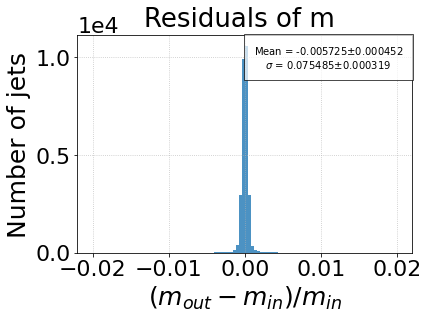

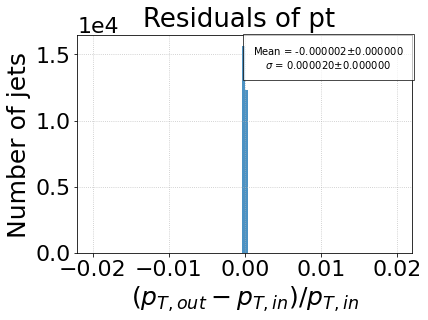

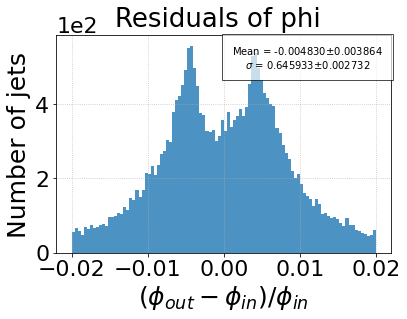

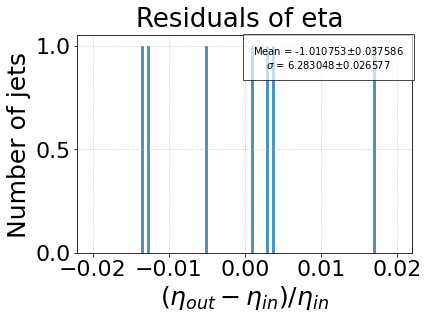

In [17]:
import utils
from scipy import stats
residual_strings = [r'$(m_{out} - m_{in}) / m_{in}$',
                    r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                    r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',    
                    r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',]

data = data.detach().numpy()
data[:,0][(data[:,0]<1e-3)] += 1
residuals = np.true_divide(pred - data, data)

range = (-.02, .02)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    print(train.columns[kk],'Mean: ', mean, '\pm', sem, ' Sigma: ', std, '\pm', std_err )
    plt.text(.75, .9, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)
    fig_name = '200_no_norm_residual_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

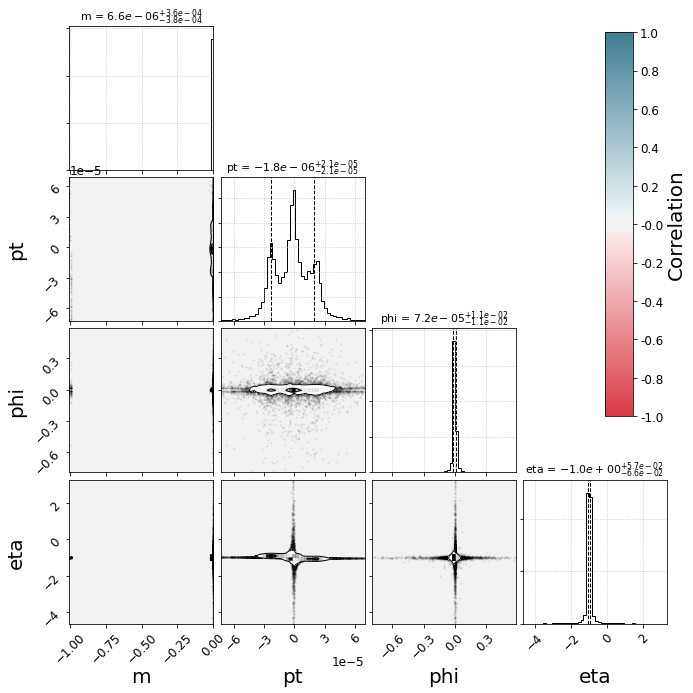

In [18]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'m': residuals[:, 0], 'pt': residuals[:, 1], 'phi': residuals[:, 2], 'eta': residuals[:, 3]})
save = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['m', 'pt', 'phi', 'eta']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = '200_3D_no_norm_corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)